# Autoencoders in SciKeras

Autencoders are an approach to use nearual networks to distill data into it's most important features, thereby compressing the data. We will be following the [Keras tutorial](https://blog.keras.io/building-autoencoders-in-keras.html) on the topic, which goes much more in depth and breadth than we will here. You are highly encouraged to check out that tutorial if you want to learn about autoencoders in the general sense.

## Table of contents

* [1. Setup](#1.-Setup)
* [2. Data](#2.-Data)
* [3. Define Keras Model](#3.-Define-Keras-Model)
* [4. Training](#4.-Training)
* [5. Explore Results](#5.-Explore-Results)

## 1. Setup

In [1]:
try:
    import scikeras
except ImportError:
    !python -m pip install scikeras

Silence TensorFlow logging to keep output succinct.

In [2]:
import warnings
from tensorflow import get_logger
get_logger().setLevel('ERROR')
warnings.filterwarnings("ignore", message="Setting the random state for TF")

In [3]:
import numpy as np
from scikeras.wrappers import KerasClassifier, KerasRegressor
from tensorflow import keras

## 2. Data

We load the dataset from the Keras tutorial. The dataset consists of images of cats and dogs.

In [4]:
from tensorflow.keras.datasets import mnist
import numpy as np


(x_train, _), (x_test, _) = mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print(x_train.shape)
print(x_test.shape)

(60000, 784)
(10000, 784)


## 3. Define Keras Model

We will be defining a very simple autencoder. We define _three_ model building methods:

1. One to build a full end-to-end autoencoder.
2. One to create a model that includes only the encoder portion.
3. One that creates a model that includes only the decoder portion.

The only variable we give our model is the encoding dimensions, which will be a hyperparemter of our final transformer.

In [5]:
from tensorflow import keras


def get_fit_model(encoding_dim: int) -> keras.Model:
    """Get an autoencoder.

    This autoencoder compresses a 28x28 image (784 pixels) down to a feature of length
    `encoding_dim`, and tries to reconstruct the input image from that vector.
    """
    input_img = keras.Input(shape=(784,), name="input")
    encoded = keras.layers.Dense(encoding_dim, activation='relu', name="encoded")(input_img)
    decoded = keras.layers.Dense(784, activation='sigmoid', name="output")(encoded)
    autoencoder_model = keras.Model(input_img, decoded)
    return autoencoder_model

def get_tf_model(fit_model: keras.Model) -> keras.Model:
    """Get an encoder model.

    We do this by extracting the encoding layer from the fitted autoencoder model.
    """
    return keras.Model(fit_model.get_layer("input").input, fit_model.get_layer("encoded").output)

def get_inverse_tf_model(fit_model: keras.Model, encoding_dim: int) -> keras.Model:
    """Get an deencoder model.

    We do this by extracting the deencoding layer from the fitted autoencoder model
    and adding a new Keras input layer.
    """
    encoded_input = keras.Input(shape=(encoding_dim,))
    output = fit_model.get_layer("output")(encoded_input)
    return keras.Model(encoded_input, output)

Next we create a class that that will enable the `transform` and `fit_transform` methods, as well as integrating all three of our models into a single estimator.

In [6]:
from sklearn.base import TransformerMixin, clone
from scikeras.wrappers import BaseWrapper


class KerasTransformer(BaseWrapper, TransformerMixin):
    """A class that enables transform and fit_transform.
    """

    def __init__(self, *args, tf_est: BaseWrapper = None, inv_tf_est: BaseWrapper = None, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.tf_est = tf_est
        self.inv_tf_est = inv_tf_est


    def fit(self, X, sample_weight=None):
        super().fit(X=X, y=X, sample_weight=sample_weight)
        self.tf_est_ = clone(self.tf_est)
        self.inv_tf_est_ = clone(self.inv_tf_est)
        self.tf_est_.set_params(fit_model=self.model_)
        self.inv_tf_est_.set_params(fit_model=self.model_, encoding_dim=self.encoding_dim)
        X = self.feature_encoder_.transform(X)
        self.tf_est_.initialize(X=X)
        X_tf = self.tf_est_.predict(X=X)
        self.inv_tf_est_.initialize(X_tf)
        return self

    def transform(self, X):
        X = self.feature_encoder_.transform(X)
        X_tf = self.tf_est_.predict(X)
        return X_tf
    
    def inverse_transform(self, X_tf):
        X = self.inv_tf_est_.predict(X_tf)
        X = self.feature_encoder_.inverse_transform(X)
        return X

Next, we wrap the Keras Model with Scikeras. Note that for our encoder/decoder estimators, we do not need to provide a loss function since no training will be done. We do however need to have the `fit_model` and `encoding_dim` so that these will be settable by `BaseWrapper.set_params`.

In [7]:
tf_est = BaseWrapper(model=get_tf_model, fit_model=None, verbose=0)
inv_tf_est = BaseWrapper(model=get_inverse_tf_model, fit_model=None, encoding_dim=None, verbose=0)
autoencoder = KerasTransformer(model=get_fit_model, tf_est=tf_est, inv_tf_est=inv_tf_est, loss="binary_crossentropy", encoding_dim=32, epochs=5)

## 4. Training

To train the model, we pass the input images as both the features and the target. This will train the layers to compress the data as accurately as possible between the encoder and decoder. Note that we only pass the `X` parameter, since we defined the mapping `y=X` in `KerasTransformer.fit` above.

In [8]:
_ = autoencoder.fit(X=x_train)

Epoch 1/5


   1/1875 [..............................] - ETA: 14:22 - loss: 0.6926

  29/1875 [..............................] - ETA: 3s - loss: 0.5467   

  60/1875 [..............................] - ETA: 3s - loss: 0.4624

  92/1875 [>.............................] - ETA: 2s - loss: 0.4185

 124/1875 [>.............................] - ETA: 2s - loss: 0.3908

 155/1875 [=>............................] - ETA: 2s - loss: 0.3717

 186/1875 [=>............................] - ETA: 2s - loss: 0.3567

 218/1875 [==>...........................] - ETA: 2s - loss: 0.3441

 249/1875 [==>...........................] - ETA: 2s - loss: 0.3338

 280/1875 [===>..........................] - ETA: 2s - loss: 0.3249

 311/1875 [===>..........................] - ETA: 2s - loss: 0.3170

 343/1875 [====>.........................] - ETA: 2s - loss: 0.3097

 374/1875 [====>.........................] - ETA: 2s - loss: 0.3034

 406/1875 [=====>........................] - ETA: 2s - loss: 0.2975

 437/1875 [=====>........................] - ETA: 2s - loss: 0.2922

 469/1875 [======>.......................] - ETA: 2s - loss: 0.2873

 500/1875 [=======>......................] - ETA: 2s - loss: 0.2828

 530/1875 [=======>......................] - ETA: 2s - loss: 0.2788

 562/1875 [=======>......................] - ETA: 2s - loss: 0.2748

 591/1875 [========>.....................] - ETA: 2s - loss: 0.2714

 625/1875 [=========>....................] - ETA: 2s - loss: 0.2677

 654/1875 [=========>....................] - ETA: 1s - loss: 0.2646

 679/1875 [=========>....................] - ETA: 1s - loss: 0.2622

 706/1875 [==========>...................] - ETA: 1s - loss: 0.2596

 734/1875 [==========>...................] - ETA: 1s - loss: 0.2571

 763/1875 [===========>..................] - ETA: 1s - loss: 0.2546

 791/1875 [===========>..................] - ETA: 1s - loss: 0.2522

 818/1875 [============>.................] - ETA: 1s - loss: 0.2501

 846/1875 [============>.................] - ETA: 1s - loss: 0.2480

 875/1875 [=============>................] - ETA: 1s - loss: 0.2458

 910/1875 [=============>................] - ETA: 1s - loss: 0.2434

 942/1875 [==============>...............] - ETA: 1s - loss: 0.2412

 976/1875 [==============>...............] - ETA: 1s - loss: 0.2390

1009/1875 [===============>..............] - ETA: 1s - loss: 0.2370

1043/1875 [===============>..............] - ETA: 1s - loss: 0.2350

1075/1875 [================>.............] - ETA: 1s - loss: 0.2331

1108/1875 [================>.............] - ETA: 1s - loss: 0.2313

1142/1875 [=================>............] - ETA: 1s - loss: 0.2295

1176/1875 [=================>............] - ETA: 1s - loss: 0.2278

1211/1875 [==================>...........] - ETA: 1s - loss: 0.2260

1243/1875 [==================>...........] - ETA: 1s - loss: 0.2245

1277/1875 [===================>..........] - ETA: 0s - loss: 0.2229

1310/1875 [===================>..........] - ETA: 0s - loss: 0.2214

1344/1875 [====================>.........] - ETA: 0s - loss: 0.2200

1377/1875 [=====================>........] - ETA: 0s - loss: 0.2186

1409/1875 [=====================>........] - ETA: 0s - loss: 0.2173

1442/1875 [======================>.......] - ETA: 0s - loss: 0.2159

1474/1875 [======================>.......] - ETA: 0s - loss: 0.2147

1507/1875 [=======================>......] - ETA: 0s - loss: 0.2135

1540/1875 [=======================>......] - ETA: 0s - loss: 0.2122

1574/1875 [========================>.....] - ETA: 0s - loss: 0.2110

1607/1875 [========================>.....] - ETA: 0s - loss: 0.2099

1640/1875 [=========================>....] - ETA: 0s - loss: 0.2088

1675/1875 [=========================>....] - ETA: 0s - loss: 0.2076

1708/1875 [==========================>...] - ETA: 0s - loss: 0.2065

1742/1875 [==========================>...] - ETA: 0s - loss: 0.2055

1775/1875 [===========================>..] - ETA: 0s - loss: 0.2045

1810/1875 [===========================>..] - ETA: 0s - loss: 0.2034

1844/1875 [============================>.] - ETA: 0s - loss: 0.2024

1875/1875 [==============================] - 3s 2ms/step - loss: 0.2015


Epoch 2/5
   1/1875 [..............................] - ETA: 3s - loss: 0.1076

  35/1875 [..............................] - ETA: 2s - loss: 0.1087

  67/1875 [>.............................] - ETA: 2s - loss: 0.1081

 102/1875 [>.............................] - ETA: 2s - loss: 0.1079

 134/1875 [=>............................] - ETA: 2s - loss: 0.1079

 169/1875 [=>............................] - ETA: 2s - loss: 0.1078

 203/1875 [==>...........................] - ETA: 2s - loss: 0.1078

 234/1875 [==>...........................] - ETA: 2s - loss: 0.1078

 262/1875 [===>..........................] - ETA: 2s - loss: 0.1077

 292/1875 [===>..........................] - ETA: 2s - loss: 0.1076

 326/1875 [====>.........................] - ETA: 2s - loss: 0.1075

 359/1875 [====>.........................] - ETA: 2s - loss: 0.1075

 393/1875 [=====>........................] - ETA: 2s - loss: 0.1074

 425/1875 [=====>........................] - ETA: 2s - loss: 0.1073

 459/1875 [======>.......................] - ETA: 2s - loss: 0.1072

 491/1875 [======>.......................] - ETA: 2s - loss: 0.1071

 523/1875 [=======>......................] - ETA: 2s - loss: 0.1071

 557/1875 [=======>......................] - ETA: 2s - loss: 0.1070

 589/1875 [========>.....................] - ETA: 1s - loss: 0.1069

 622/1875 [========>.....................] - ETA: 1s - loss: 0.1069

 654/1875 [=========>....................] - ETA: 1s - loss: 0.1068

 688/1875 [==========>...................] - ETA: 1s - loss: 0.1067

 720/1875 [==========>...................] - ETA: 1s - loss: 0.1067

 752/1875 [===========>..................] - ETA: 1s - loss: 0.1066

 785/1875 [===========>..................] - ETA: 1s - loss: 0.1065

 817/1875 [============>.................] - ETA: 1s - loss: 0.1065

 849/1875 [============>.................] - ETA: 1s - loss: 0.1064

 878/1875 [=============>................] - ETA: 1s - loss: 0.1063

 910/1875 [=============>................] - ETA: 1s - loss: 0.1063

 942/1875 [==============>...............] - ETA: 1s - loss: 0.1062

 974/1875 [==============>...............] - ETA: 1s - loss: 0.1061

1006/1875 [===============>..............] - ETA: 1s - loss: 0.1061

1038/1875 [===============>..............] - ETA: 1s - loss: 0.1060

1071/1875 [================>.............] - ETA: 1s - loss: 0.1060

1102/1875 [================>.............] - ETA: 1s - loss: 0.1059

1134/1875 [=================>............] - ETA: 1s - loss: 0.1058

1166/1875 [=================>............] - ETA: 1s - loss: 0.1058

1199/1875 [==================>...........] - ETA: 1s - loss: 0.1057

1230/1875 [==================>...........] - ETA: 1s - loss: 0.1057

1259/1875 [===================>..........] - ETA: 0s - loss: 0.1056

1290/1875 [===================>..........] - ETA: 0s - loss: 0.1056

1321/1875 [====================>.........] - ETA: 0s - loss: 0.1055

1353/1875 [====================>.........] - ETA: 0s - loss: 0.1055

1385/1875 [=====================>........] - ETA: 0s - loss: 0.1054

1417/1875 [=====================>........] - ETA: 0s - loss: 0.1054

1449/1875 [======================>.......] - ETA: 0s - loss: 0.1053

1481/1875 [======================>.......] - ETA: 0s - loss: 0.1052

1512/1875 [=======================>......] - ETA: 0s - loss: 0.1052

1543/1875 [=======================>......] - ETA: 0s - loss: 0.1051

1575/1875 [========================>.....] - ETA: 0s - loss: 0.1051

1607/1875 [========================>.....] - ETA: 0s - loss: 0.1050

1639/1875 [=========================>....] - ETA: 0s - loss: 0.1050

1670/1875 [=========================>....] - ETA: 0s - loss: 0.1049

1701/1875 [==========================>...] - ETA: 0s - loss: 0.1049

1732/1875 [==========================>...] - ETA: 0s - loss: 0.1048

1763/1875 [===========================>..] - ETA: 0s - loss: 0.1048

1794/1875 [===========================>..] - ETA: 0s - loss: 0.1047

1826/1875 [============================>.] - ETA: 0s - loss: 0.1047

1857/1875 [============================>.] - ETA: 0s - loss: 0.1047

1875/1875 [==============================] - 3s 2ms/step - loss: 0.1046


Epoch 3/5
   1/1875 [..............................] - ETA: 4s - loss: 0.1071

  32/1875 [..............................] - ETA: 3s - loss: 0.0984

  64/1875 [>.............................] - ETA: 2s - loss: 0.0977

  95/1875 [>.............................] - ETA: 2s - loss: 0.0976

 125/1875 [=>............................] - ETA: 2s - loss: 0.0976

 156/1875 [=>............................] - ETA: 2s - loss: 0.0977

 188/1875 [==>...........................] - ETA: 2s - loss: 0.0977

 219/1875 [==>...........................] - ETA: 2s - loss: 0.0978

 251/1875 [===>..........................] - ETA: 2s - loss: 0.0979

 283/1875 [===>..........................] - ETA: 2s - loss: 0.0979

 315/1875 [====>.........................] - ETA: 2s - loss: 0.0979

 347/1875 [====>.........................] - ETA: 2s - loss: 0.0979

 378/1875 [=====>........................] - ETA: 2s - loss: 0.0979

 409/1875 [=====>........................] - ETA: 2s - loss: 0.0979

 440/1875 [======>.......................] - ETA: 2s - loss: 0.0979

 471/1875 [======>.......................] - ETA: 2s - loss: 0.0979

 502/1875 [=======>......................] - ETA: 2s - loss: 0.0979

 534/1875 [=======>......................] - ETA: 2s - loss: 0.0979

 566/1875 [========>.....................] - ETA: 2s - loss: 0.0978

 599/1875 [========>.....................] - ETA: 2s - loss: 0.0978

 631/1875 [=========>....................] - ETA: 2s - loss: 0.0978

 663/1875 [=========>....................] - ETA: 1s - loss: 0.0978

 696/1875 [==========>...................] - ETA: 1s - loss: 0.0978

 728/1875 [==========>...................] - ETA: 1s - loss: 0.0978

 759/1875 [===========>..................] - ETA: 1s - loss: 0.0978

 792/1875 [===========>..................] - ETA: 1s - loss: 0.0978

 821/1875 [============>.................] - ETA: 1s - loss: 0.0978

 847/1875 [============>.................] - ETA: 1s - loss: 0.0978

 874/1875 [============>.................] - ETA: 1s - loss: 0.0978

 900/1875 [=============>................] - ETA: 1s - loss: 0.0978

 925/1875 [=============>................] - ETA: 1s - loss: 0.0978

 955/1875 [==============>...............] - ETA: 1s - loss: 0.0978

 986/1875 [==============>...............] - ETA: 1s - loss: 0.0977

1017/1875 [===============>..............] - ETA: 1s - loss: 0.0977

1048/1875 [===============>..............] - ETA: 1s - loss: 0.0977

1080/1875 [================>.............] - ETA: 1s - loss: 0.0977

1106/1875 [================>.............] - ETA: 1s - loss: 0.0977

1133/1875 [=================>............] - ETA: 1s - loss: 0.0977

1163/1875 [=================>............] - ETA: 1s - loss: 0.0977

1198/1875 [==================>...........] - ETA: 1s - loss: 0.0977

1224/1875 [==================>...........] - ETA: 1s - loss: 0.0977

1254/1875 [===================>..........] - ETA: 1s - loss: 0.0977

1283/1875 [===================>..........] - ETA: 0s - loss: 0.0977

1312/1875 [===================>..........] - ETA: 0s - loss: 0.0977

1343/1875 [====================>.........] - ETA: 0s - loss: 0.0977

1374/1875 [====================>.........] - ETA: 0s - loss: 0.0976

1405/1875 [=====================>........] - ETA: 0s - loss: 0.0976

1436/1875 [=====================>........] - ETA: 0s - loss: 0.0976

1468/1875 [======================>.......] - ETA: 0s - loss: 0.0976

1499/1875 [======================>.......] - ETA: 0s - loss: 0.0976

1529/1875 [=======================>......] - ETA: 0s - loss: 0.0976

1560/1875 [=======================>......] - ETA: 0s - loss: 0.0976

1593/1875 [========================>.....] - ETA: 0s - loss: 0.0976

1624/1875 [========================>.....] - ETA: 0s - loss: 0.0976

1656/1875 [=========================>....] - ETA: 0s - loss: 0.0976

1688/1875 [==========================>...] - ETA: 0s - loss: 0.0976

1720/1875 [==========================>...] - ETA: 0s - loss: 0.0976

1752/1875 [===========================>..] - ETA: 0s - loss: 0.0975

1784/1875 [===========================>..] - ETA: 0s - loss: 0.0975

1814/1875 [============================>.] - ETA: 0s - loss: 0.0975

1846/1875 [============================>.] - ETA: 0s - loss: 0.0975

1875/1875 [==============================] - 3s 2ms/step - loss: 0.0975


Epoch 4/5
   1/1875 [..............................] - ETA: 5s - loss: 0.0972

  33/1875 [..............................] - ETA: 2s - loss: 0.0955

  65/1875 [>.............................] - ETA: 2s - loss: 0.0957

  91/1875 [>.............................] - ETA: 3s - loss: 0.0959

 118/1875 [>.............................] - ETA: 3s - loss: 0.0960

 145/1875 [=>............................] - ETA: 3s - loss: 0.0960

 173/1875 [=>............................] - ETA: 3s - loss: 0.0960

 195/1875 [==>...........................] - ETA: 3s - loss: 0.0960

 218/1875 [==>...........................] - ETA: 3s - loss: 0.0961

 245/1875 [==>...........................] - ETA: 3s - loss: 0.0961

 273/1875 [===>..........................] - ETA: 3s - loss: 0.0961

 300/1875 [===>..........................] - ETA: 2s - loss: 0.0962

 324/1875 [====>.........................] - ETA: 2s - loss: 0.0962

 352/1875 [====>.........................] - ETA: 2s - loss: 0.0962

 384/1875 [=====>........................] - ETA: 2s - loss: 0.0962

 412/1875 [=====>........................] - ETA: 2s - loss: 0.0962

 443/1875 [======>.......................] - ETA: 2s - loss: 0.0961

 470/1875 [======>.......................] - ETA: 2s - loss: 0.0961

 495/1875 [======>.......................] - ETA: 2s - loss: 0.0961

 527/1875 [=======>......................] - ETA: 2s - loss: 0.0961

 546/1875 [=======>......................] - ETA: 2s - loss: 0.0961

 572/1875 [========>.....................] - ETA: 2s - loss: 0.0961

 596/1875 [========>.....................] - ETA: 2s - loss: 0.0961

 623/1875 [========>.....................] - ETA: 2s - loss: 0.0961

 651/1875 [=========>....................] - ETA: 2s - loss: 0.0961

 681/1875 [=========>....................] - ETA: 2s - loss: 0.0960

 710/1875 [==========>...................] - ETA: 2s - loss: 0.0960

 742/1875 [==========>...................] - ETA: 2s - loss: 0.0960

 771/1875 [===========>..................] - ETA: 2s - loss: 0.0960

 797/1875 [===========>..................] - ETA: 1s - loss: 0.0960

 826/1875 [============>.................] - ETA: 1s - loss: 0.0960

 852/1875 [============>.................] - ETA: 1s - loss: 0.0960

 879/1875 [=============>................] - ETA: 1s - loss: 0.0960

 906/1875 [=============>................] - ETA: 1s - loss: 0.0960

 931/1875 [=============>................] - ETA: 1s - loss: 0.0960

 959/1875 [==============>...............] - ETA: 1s - loss: 0.0960

 981/1875 [==============>...............] - ETA: 1s - loss: 0.0960

1012/1875 [===============>..............] - ETA: 1s - loss: 0.0960

1042/1875 [===============>..............] - ETA: 1s - loss: 0.0960

1072/1875 [================>.............] - ETA: 1s - loss: 0.0960

1103/1875 [================>.............] - ETA: 1s - loss: 0.0960

1135/1875 [=================>............] - ETA: 1s - loss: 0.0960

1166/1875 [=================>............] - ETA: 1s - loss: 0.0960

1197/1875 [==================>...........] - ETA: 1s - loss: 0.0960

1228/1875 [==================>...........] - ETA: 1s - loss: 0.0960

1259/1875 [===================>..........] - ETA: 1s - loss: 0.0960

1289/1875 [===================>..........] - ETA: 1s - loss: 0.0960

1319/1875 [====================>.........] - ETA: 1s - loss: 0.0959

1351/1875 [====================>.........] - ETA: 0s - loss: 0.0959

1383/1875 [=====================>........] - ETA: 0s - loss: 0.0959

1415/1875 [=====================>........] - ETA: 0s - loss: 0.0959

1446/1875 [======================>.......] - ETA: 0s - loss: 0.0959

1476/1875 [======================>.......] - ETA: 0s - loss: 0.0959

1507/1875 [=======================>......] - ETA: 0s - loss: 0.0959

1539/1875 [=======================>......] - ETA: 0s - loss: 0.0959

1569/1875 [========================>.....] - ETA: 0s - loss: 0.0959

1598/1875 [========================>.....] - ETA: 0s - loss: 0.0959

1628/1875 [=========================>....] - ETA: 0s - loss: 0.0959

1654/1875 [=========================>....] - ETA: 0s - loss: 0.0959

1684/1875 [=========================>....] - ETA: 0s - loss: 0.0959

1716/1875 [==========================>...] - ETA: 0s - loss: 0.0959

1746/1875 [==========================>...] - ETA: 0s - loss: 0.0959

1777/1875 [===========================>..] - ETA: 0s - loss: 0.0959

1807/1875 [===========================>..] - ETA: 0s - loss: 0.0959

1838/1875 [============================>.] - ETA: 0s - loss: 0.0959

1869/1875 [============================>.] - ETA: 0s - loss: 0.0959

1875/1875 [==============================] - 3s 2ms/step - loss: 0.0959


Epoch 5/5
   1/1875 [..............................] - ETA: 2s - loss: 0.0970

  32/1875 [..............................] - ETA: 2s - loss: 0.0956

  63/1875 [>.............................] - ETA: 2s - loss: 0.0960

  94/1875 [>.............................] - ETA: 2s - loss: 0.0959

 125/1875 [=>............................] - ETA: 2s - loss: 0.0958

 156/1875 [=>............................] - ETA: 2s - loss: 0.0958

 187/1875 [=>............................] - ETA: 2s - loss: 0.0958

 218/1875 [==>...........................] - ETA: 2s - loss: 0.0958

 248/1875 [==>...........................] - ETA: 2s - loss: 0.0958

 279/1875 [===>..........................] - ETA: 2s - loss: 0.0958

 310/1875 [===>..........................] - ETA: 2s - loss: 0.0957

 340/1875 [====>.........................] - ETA: 2s - loss: 0.0957

 371/1875 [====>.........................] - ETA: 2s - loss: 0.0957

 402/1875 [=====>........................] - ETA: 2s - loss: 0.0956

 434/1875 [=====>........................] - ETA: 2s - loss: 0.0956

 463/1875 [======>.......................] - ETA: 2s - loss: 0.0955

 494/1875 [======>.......................] - ETA: 2s - loss: 0.0955

 525/1875 [=======>......................] - ETA: 2s - loss: 0.0955

 557/1875 [=======>......................] - ETA: 2s - loss: 0.0955

 589/1875 [========>.....................] - ETA: 2s - loss: 0.0955

 620/1875 [========>.....................] - ETA: 2s - loss: 0.0954

 652/1875 [=========>....................] - ETA: 2s - loss: 0.0954

 683/1875 [=========>....................] - ETA: 1s - loss: 0.0954

 713/1875 [==========>...................] - ETA: 1s - loss: 0.0954

 744/1875 [==========>...................] - ETA: 1s - loss: 0.0954

 776/1875 [===========>..................] - ETA: 1s - loss: 0.0954

 808/1875 [===========>..................] - ETA: 1s - loss: 0.0954

 839/1875 [============>.................] - ETA: 1s - loss: 0.0954

 871/1875 [============>.................] - ETA: 1s - loss: 0.0954

 903/1875 [=============>................] - ETA: 1s - loss: 0.0954

 935/1875 [=============>................] - ETA: 1s - loss: 0.0954

 967/1875 [==============>...............] - ETA: 1s - loss: 0.0954

 999/1875 [==============>...............] - ETA: 1s - loss: 0.0954

1031/1875 [===============>..............] - ETA: 1s - loss: 0.0954

1063/1875 [================>.............] - ETA: 1s - loss: 0.0954

1095/1875 [================>.............] - ETA: 1s - loss: 0.0953

1127/1875 [=================>............] - ETA: 1s - loss: 0.0953

1158/1875 [=================>............] - ETA: 1s - loss: 0.0953

1190/1875 [==================>...........] - ETA: 1s - loss: 0.0953

1222/1875 [==================>...........] - ETA: 1s - loss: 0.0953

1255/1875 [===================>..........] - ETA: 1s - loss: 0.0953

1286/1875 [===================>..........] - ETA: 0s - loss: 0.0953

1318/1875 [====================>.........] - ETA: 0s - loss: 0.0953

1349/1875 [====================>.........] - ETA: 0s - loss: 0.0953

1382/1875 [=====================>........] - ETA: 0s - loss: 0.0953

1413/1875 [=====================>........] - ETA: 0s - loss: 0.0953

1443/1875 [======================>.......] - ETA: 0s - loss: 0.0953

1474/1875 [======================>.......] - ETA: 0s - loss: 0.0953

1505/1875 [=======================>......] - ETA: 0s - loss: 0.0953

1536/1875 [=======================>......] - ETA: 0s - loss: 0.0953

1567/1875 [========================>.....] - ETA: 0s - loss: 0.0953

1596/1875 [========================>.....] - ETA: 0s - loss: 0.0953

1626/1875 [=========================>....] - ETA: 0s - loss: 0.0953

1655/1875 [=========================>....] - ETA: 0s - loss: 0.0953

1684/1875 [=========================>....] - ETA: 0s - loss: 0.0953

1714/1875 [==========================>...] - ETA: 0s - loss: 0.0953

1744/1875 [==========================>...] - ETA: 0s - loss: 0.0953

1773/1875 [===========================>..] - ETA: 0s - loss: 0.0953

1803/1875 [===========================>..] - ETA: 0s - loss: 0.0953

1833/1875 [============================>.] - ETA: 0s - loss: 0.0953

1862/1875 [============================>.] - ETA: 0s - loss: 0.0953

1875/1875 [==============================] - 3s 2ms/step - loss: 0.0953


Next, we round trip the test dataset and explore the performance of the autoencoder.

In [9]:
roundtrip_imgs = autoencoder.inverse_transform(autoencoder.transform(x_test))

## 5. Explore Results

Let's compare our inputs to lossy decoded outputs:

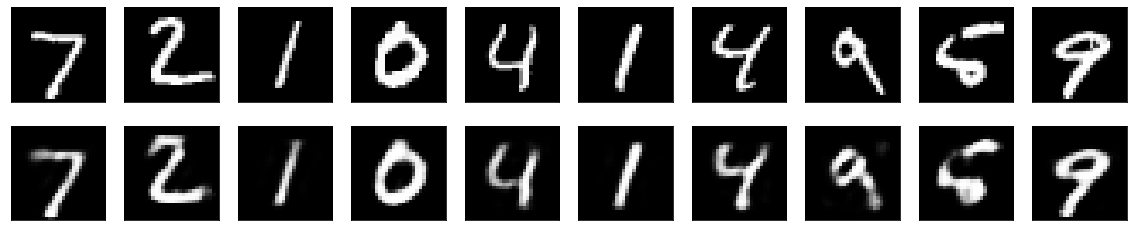

In [10]:
import matplotlib.pyplot as plt


n = 10  # How many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(roundtrip_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

What about the compression? Let's check the sizes of the arrays.

In [11]:
encoded_imgs = autoencoder.transform(x_test)
print(f"x_test.shape[1]: {x_test.shape[1]}")
print(f"encoded_imgs.shape[1]: {encoded_imgs.shape[1]}")
cr = round((encoded_imgs.nbytes/x_test.nbytes), 2)
print(f"Compression ratio: 1/{1/cr:.0f}")

x_test.shape[1]: 784
encoded_imgs.shape[1]: 32
Compression ratio: 1/25
